In [91]:
import pandas as pd

# Read the data from the CSV file
path = r'C:\Users\hp\Desktop\newproject\ssproject\Scripts\churnprediction\data\Bank_churn.csv'
df = pd.read_csv(path)

# remove the rownumber, customerid columns,surname
df = df.drop(['rownumber', 'customerid','surname'], axis=1)




In [92]:
! pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [93]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns


In [95]:
df.head()


,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [96]:


df.describe()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [97]:
# Check for missing values
df.isnull().sum()

creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
churn              0
dtype: int64

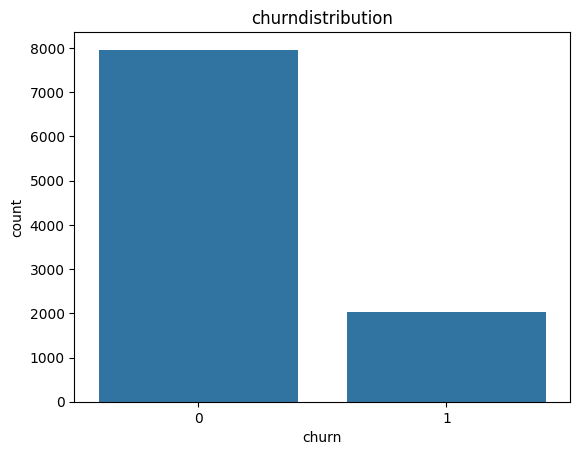

churn
0    7963
1    2037
Name: count, dtype: int64

In [98]:
# churn distribution

sns.countplot(x='churn', data=df)
plt.title('churndistribution')
plt.show()

# 
df["churn"].value_counts()

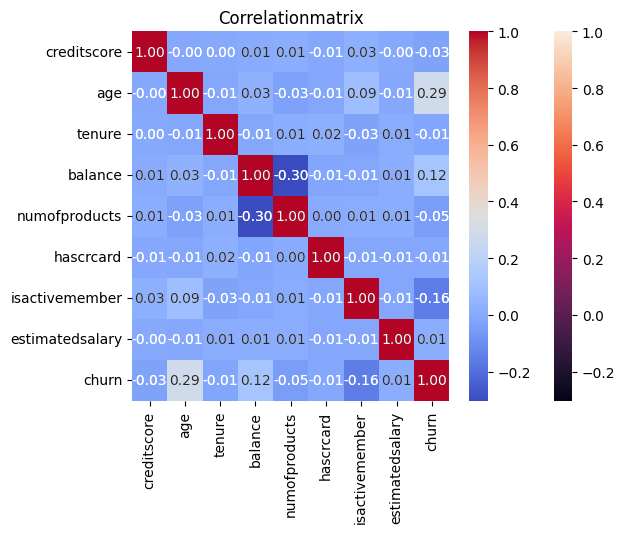

In [99]:
# Correlation matrix for numerical features alone
corr = df[numeric_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f")
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlationmatrix')
plt.show()



Distribution of Numerical Features:


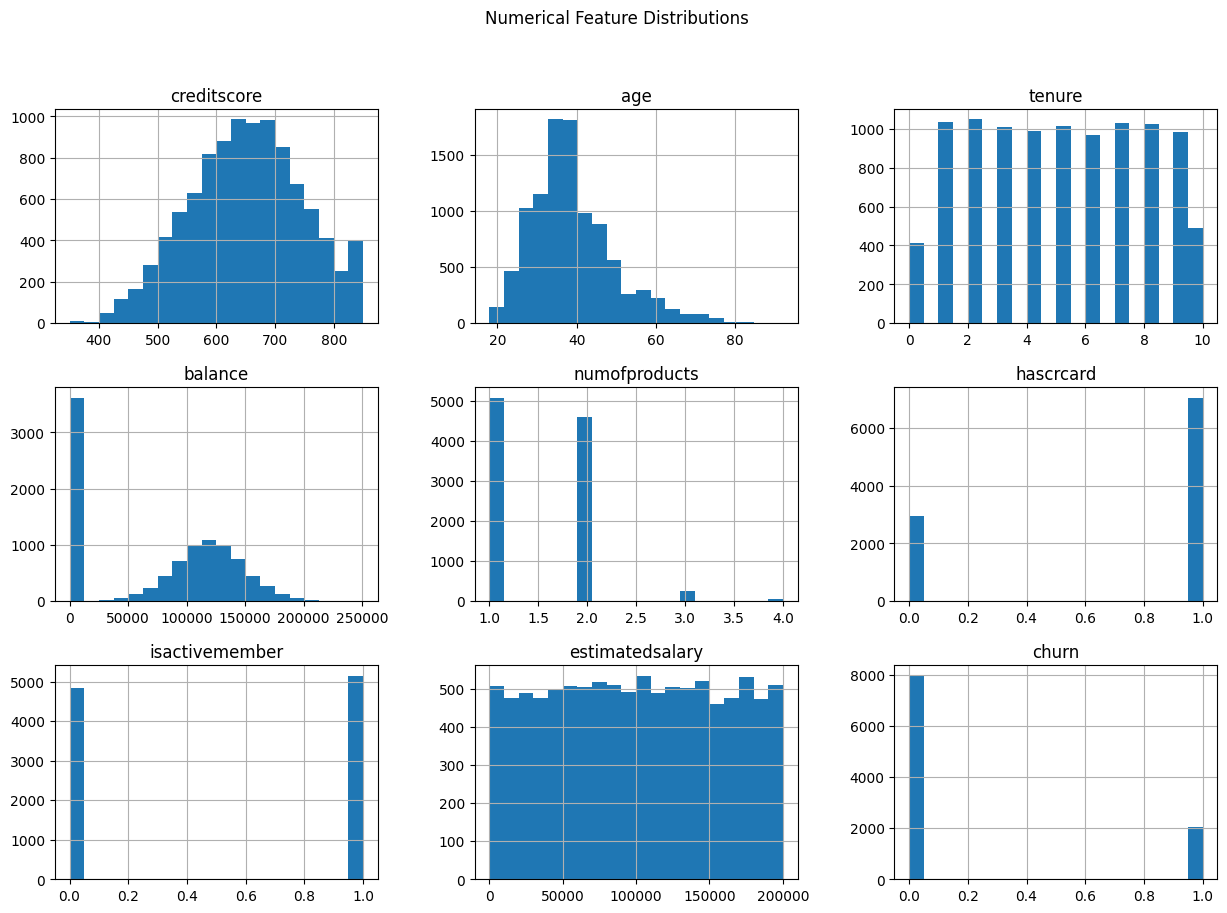

In [100]:
 # Plot distribution of numerical features
print("\nDistribution of Numerical Features:")
df.select_dtypes(include=['int64', 'float64']).hist(bins=20, figsize=(15, 10))
plt.suptitle('Numerical Feature Distributions')
plt.show()

In [101]:
# give the correlation values of the features with respect to the target variable

corr['churn'].sort_values(ascending=False)

churn              1.000000
age                0.285323
balance            0.118533
estimatedsalary    0.012097
hascrcard         -0.007138
tenure            -0.014001
creditscore       -0.027094
numofproducts     -0.047820
isactivemember    -0.156128
Name: churn, dtype: float64

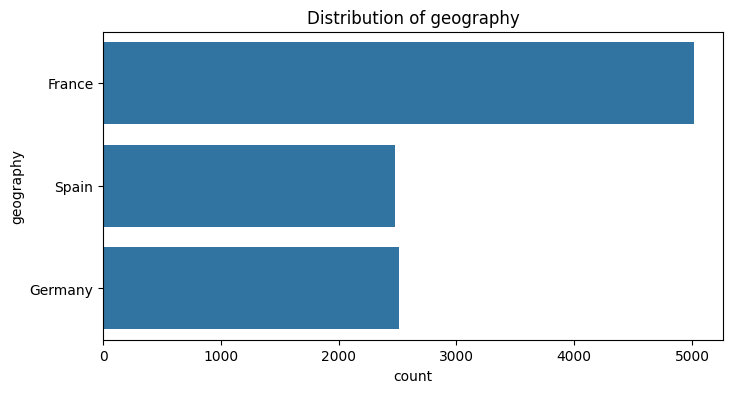

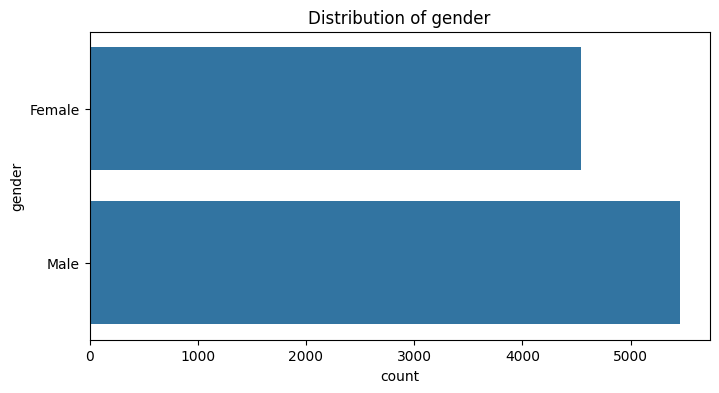

In [102]:
categorical_features = df.select_dtypes(include=['object']).columns
for feature in categorical_features:
    if feature == 'surname':
        continue
    plt.figure(figsize=(8, 4))
    sns.countplot(y=feature, data=df)
    plt.title(f'Distribution of {feature}')
    plt.show()



In [108]:
import numpy as np

# Feature Engineering
# Age Binning
df['age_bin'] = pd.cut(df['age'], bins=[20, 30, 40, 50, 60, 70, 80], labels=['20-30', '30-40', '40-50', '50-60', '60-70', '70-80'])

# Balance Binning
df['balance_bin'] = pd.cut(df['balance'], bins=[-np.inf, 0, 50000, 100000, np.inf], labels=['Negative', 'Low', 'Medium', 'High'])

# Tenure Binning
df['tenure_bin'] = pd.cut(df['tenure'], bins=[-np.inf, 1, 3, 5, 7, 10, np.inf], labels=['0-1', '1-3', '3-5', '5-7', '7-10', '10+'])

# Encoding Number of Products
df['numofproducts_cat'] = df['numofproducts'].astype('category')

# Salary Binning
df['salary_bin'] = pd.cut(df['estimatedsalary'], bins=[-np.inf, 30000, 70000, 100000, np.inf], labels=['Low', 'Medium', 'High', 'Very High'])


In [117]:
 
X = df.drop('churn', axis=1)
y = df['churn']

# Define steps for preprocessing numerical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler())])  # Standardize features

# Define steps for preprocessing categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])  # One-hot encoding
# Combine both transformers into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)



In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Assuming X_processed and y are defined as per the feature engineering process
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))


Accuracy: 0.811
Precision: 0.5524475524475524
Recall: 0.2010178117048346
ROC AUC: 0.5805960247074267


In [119]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))


Accuracy: 0.864
Precision: 0.746938775510204
Recall: 0.46564885496183206
ROC AUC: 0.7135338238717063


In [121]:
! pip install xgboost

import xgboost as xgb

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


                                              0.0/124.9 MB ? eta -:--:--
                                              0.0/124.9 MB 1.4 MB/s eta 0:01:32
                                              0.1/124.9 MB 1.1 MB/s eta 0:01:59
                                              0.2/124.9 MB 1.1 MB/s eta 0:01:49
                                              0.2/124.9 MB 1.4 MB/s eta 0:01:27
                                              0.5/124.9 MB 2.1 MB/s eta 0:01:00
                                              0.6/124.9 MB 2.2 MB/s eta 0:00:58
                                              0.7/124.9 MB 2.4 MB/s eta 0:00:53
                                              0.9/124.9 MB 2.4 MB/s eta 0:00:52
                                              1.0/124.9 MB 2.6 MB/s eta 0:00:48
                                              1.1/124.9 MB 2.6 MB/s eta 0:00:48
                                              1.3/124.9 MB 2.7 MB/s eta 0:00:46
                                              1

c:\Users\hp\Desktop\newproject\ssproject\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [122]:
from sklearn.svm import SVC

model = SVC(probability=True, kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))


Accuracy: 0.8035
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5


c:\Users\hp\Desktop\newproject\ssproject\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
